In [17]:
%reset -f

In [18]:
import anuga, anuga.parallel, numpy, time, os, glob
from anuga.operators.rate_operators import Polygonal_rate_operator
from anuga import file_function, Polygon_function, read_polygon, create_mesh_from_regions, Domain, Inlet_operator
import anuga.utilities.spatialInputUtil as su
from anuga import distribute, myid, numprocs, finalize, barrier
from anuga.parallel.parallel_operator_factory import Inlet_operator, Boyd_box_operator, Boyd_pipe_operator
from anuga import Rate_operator
from anuga import Region

import os
import numpy as np
from hymo import SWMMInpFile
import pickle
from pyswmm import Simulation, Nodes, Links, SystemStats
import matplotlib.pyplot as plt

import time
from coupling_functions.inlet_initialization import initialize_inlets
from coupling_functions.coupling import calculate_Q, calculate_Q_v2
import matplotlib

time_average = 10 # sec
dt           = 1.0    # yield step
ft           = 75 # final timestep

plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})
co = 0.6
cw = 0.6

output_frequency = 1


## Dont do inlet1 rain and multi inlet rain

do_new_coupling = True
do_surf_rain    = False
do_data_save    = True
do_print        = True
do_plot         = True
expand_polygon  = False
zero_velocity   = True
basename = 'model/terrain'


if do_surf_rain:
    file_name = 'real_example'
    inp_name = file_name + '.inp'
else:
    file_name = 'real_example_pipe_flow'
    inp_name = file_name + '.inp'

outname  = file_name
meshname = 'model/terrain.tsh'

sim = Simulation(inp_name)
inp = SWMMInpFile(inp_name)
baseline_flows = []



if do_surf_rain:
    baseline_flows = [0.5, 0.0, 0.0, 0.0]
else:
    for inflow in inp.inflows.Baseline.values:
        baseline_flows.append(inflow)
baseline_flow  = sum(baseline_flows)

if os.path.isdir('plots/') and do_plot:
    plot_path = 'plots/'
    if do_surf_rain:
        plot_name = plot_path + f'volume_and_loss_inflow_{baseline_flow}_tavg_{time_average}_multi'
    else: 
        plot_name = plot_path + f'volume_and_loss_inflow_{baseline_flow}_tavg_{time_average}_single'

riverWall_csv_files = glob.glob('model/wall/*.csv') # Make a list of the csv files in BREAKLINES

(riverWalls, riverWall_parameters) = su.readListOfRiverWalls(riverWall_csv_files)

CatchmentDictionary = {'model/kerb/kerb1.csv':0.01, 'model/kerb/kerb2.csv':0.01}
    
bounding_polygon = anuga.read_polygon('model/domain.csv')
interior_regions = anuga.read_polygon_dir(CatchmentDictionary, 'model/kerb')


create_mesh_from_regions(bounding_polygon,
    boundary_tags={'inflow': [12], 'bottom': [0,1,2,3,4,5], 'top': [7,8,9,10,11], 'outflow': [6]},
    #boundary_tags=None,
    # maximum_triangle_area = 0.25,
    maximum_triangle_area = 2,
    breaklines = riverWalls.values(),
    interior_regions = interior_regions,
    filename = meshname,
    use_cache = False,
    verbose = False)


domain = anuga.Domain(meshname, use_cache=False, verbose=False)
# domain.set_minimum_storable_height(0.0)
domain.set_minimum_storable_height(0.0001)

domain.riverwallData.create_riverwalls(riverWalls,verbose = False) 
domain.set_name(outname) 

domain.set_quantity('friction', 0.025)
domain.set_quantity('stage', 0)
domain.set_quantity('elevation', filename=basename+'.csv', use_cache=False, verbose=False, alpha=0.99)

Br = anuga.Reflective_boundary(domain)  
# Bd = anuga.Dirichlet_boundary([0,0,0])

Bd = anuga.Dirichlet_boundary([-1,0,0])

domain.set_boundary({'inflow': Bd, 'bottom': Bd, 'outflow': Bd, 'top': Bd})

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})


 o  Retrieving project data

/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/pmesh/mesh_interface.py:190: UserWarning: Segment 13 was not assigned a boundary_tag.Default tag "exterior" will be assigned to missing segment
  warnings.warn(msg, UserWarning)
/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/structures/riverwall.py:124: RuntimeWarning: invalid value encountered in cast
  self.hydraulic_properties_rowIndex=numpy.array([default_int]).astype(int)


In [19]:
node_ids      = [node.nodeid for node in Nodes(sim)]
in_node_ids   = [node.nodeid for node in Nodes(sim) if node.is_junction()]
n_in_nodes    = len(in_node_ids)

### Initialize inlet operators
inlet_area     = np.full((n_in_nodes),1.167)
Q_in_0         = n_in_nodes*[0.0]
Q_in_cumu      = sum(Q_in_0)
inlet_vol_cumu = 0
n_sides        = 4

inlet_operators,inlet_elevation,_,_ = initialize_inlets(domain, sim, inp, n_sides, inlet_area, Q_in_0, rotation = -np.pi/4, zero_velocity = zero_velocity, expand_polygon = expand_polygon)

if do_surf_rain:
    rain_operators,_,_,_ = initialize_inlets(domain, sim, inp, n_sides, inlet_area, baseline_flows, rotation = -np.pi/4, zero_velocity = zero_velocity, expand_polygon = expand_polygon)
else:
    rain_operators,_,_,_ = initialize_inlets(domain, sim, inp, n_sides, inlet_area, Q_in_0, rotation = -np.pi/4, zero_velocity = zero_velocity, expand_polygon = expand_polygon)

inlet_weir_length = 2*np.sqrt(np.pi*inlet_area)

Q_in_old       = np.zeros_like(inlet_elevation)
outfall_vol    = 0

times            = []
losses           = []
outfall_vols     = []
boundary_fluxs    = []
applied_inflows  = []
correct_vols  = []
real_vols     = []
anuga_depths_out = []
sewer_volumes    = []
inlet_floods     = []
domain_volumes   = []
if do_data_save:
    Q_ins          = []
    conduit_depths = []
    node_heads     = []
    cumulative_inlet_flooding = np.array(n_in_nodes*[0.0])
    cumulative_inlet_flow     = np.array(n_in_nodes*[0.0])


system_routing = SystemStats(sim)

zero_velocity: True
expand_polygon: False
zero_velocity: True
expand_polygon: False


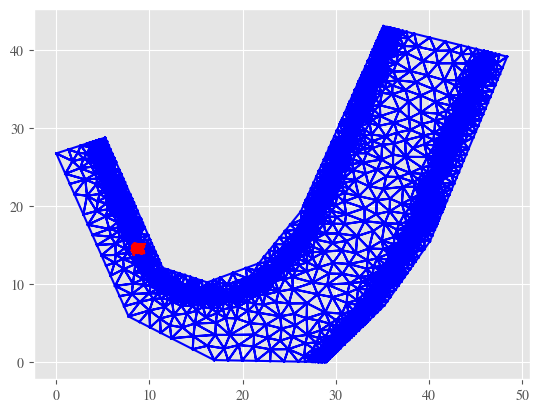

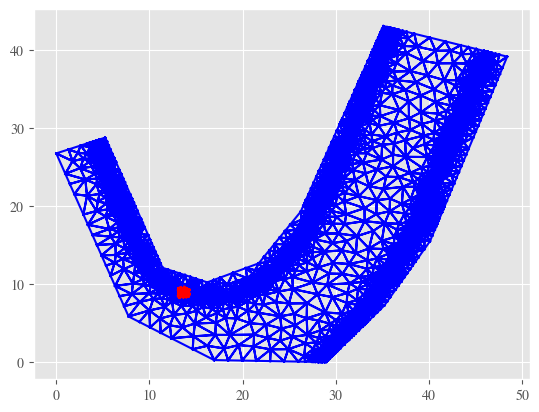

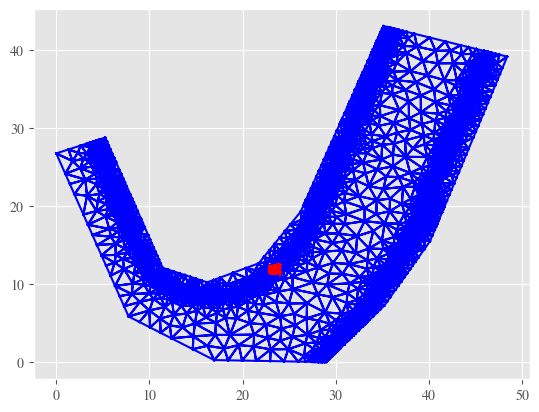

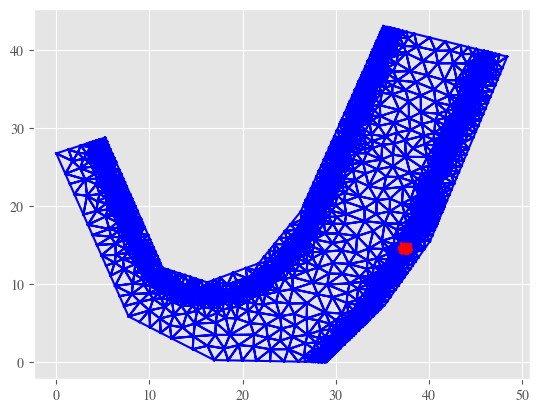

In [20]:
for node in Nodes(sim):
    if node.is_junction():
        inlet_operators[node.nodeid].inlet.region.plot_region()

In [21]:
baseline_flows

[0.5, 0.0, 0.0, 0.0]

In [22]:
old_inlet_flood_vol = [0 for node in Nodes(sim) if node.is_junction()]
invert_elev = [node.invert_elevation for node in Nodes(sim) if node.is_junction()]
max_depths  = [inp.junctions.loc[node.nodeid].Max_Depth for node in Nodes(sim) if node.is_junction()]

In [23]:
wall_clock_start = time.perf_counter()
sim.start()
old_inlet_vol = [- node.statistics['lateral_infow_vol'] + node.statistics['flooding_volume'] for node in Nodes(sim) if node.is_junction()]
node_volume    = sum(old_inlet_vol)
link_volume_0 = 0
for link in Links(sim):
    link_volume_0 += link.volume

for t in domain.evolve(yieldstep=dt, finaltime=ft):
    anuga_depths = np.array([inlet_operators[in_id].inlet.get_average_depth() for in_id in in_node_ids])

    # Reset link volume at every iteration and sum volumes
    link_volume = sum([link.volume for link in Links(sim)])
    # link_volume = 0
    # for link in Links(sim):
    #     link_volume += link.volume

    if do_data_save:
        conduit_depths.append(np.array([link.depth for link in Links(sim)]))

    domain_volume        = domain.get_water_volume()
    sewer_volume         = link_volume + node_volume
    boundary_flux        = domain.get_boundary_flux_integral() # actually volume
    outfall_vol         += Nodes(sim)['Outfall_1'].total_inflow*dt

    total_volume_correct = t*sum(baseline_flows) + 0.5*sum(baseline_flows) + boundary_flux + link_volume_0 - outfall_vol 
    total_volume_real    = domain_volume + sewer_volume
    applied_inflow       = (system_routing.routing_stats["external_inflow"] - Q_in_cumu)*dt

    node_head = np.array([node.head for node in Nodes(sim) if node.is_junction()])
    
    if do_new_coupling:
        inlet_volumes = [inlet_operators[nodeid].inlet.get_total_water_volume() for nodeid in in_node_ids]
        Q_in = 1.0 * calculate_Q_v2(node_head, anuga_depths, inlet_elevation, inlet_weir_length, inlet_area, inlet_volumes, dt, cw = cw, co = co)
    else:
        Q_in = 1.0 * calculate_Q(node_head, anuga_depths, inlet_elevation, inlet_weir_length, inlet_area, dt, cw = cw, co = co)

    Q_in       = ((time_average - dt)*Q_in_old + dt*Q_in)/time_average
    Q_in_old   = Q_in.copy()
    Q_in_cumu += sum(Q_in)
    
    if do_data_save:
        Q_ins.append(Q_in.copy())
        node_heads.append(node_head.copy())
        anuga_depths_out.append(anuga_depths.copy())

    # Simulate sewer with flow input
    for nodeid, Qin in zip(in_node_ids, Q_in): 
        Nodes(sim)[nodeid].generated_inflow(Qin)      
    sim.step_advance(dt) 
    sim.next()

    inlet_vol       = [- node.statistics['lateral_infow_vol'] + node.statistics['flooding_volume'] for node in Nodes(sim) if node.is_junction()]
    inlet_flow      = [(new_vol - old_vol)/dt for new_vol, old_vol in zip(inlet_vol,old_inlet_vol)]
    inlet_vol_cumu += sum(inlet_vol)
    old_inlet_vol   = inlet_vol.copy()

    inlet_idx = 0
    if do_surf_rain:
        for node in Nodes(sim):
            if node.is_junction():
                inlet_operators[node.nodeid].set_Q(inlet_flow[inlet_idx])
                inlet_idx += 1

    else:
         for node in Nodes(sim):
            if node.is_junction():
                inlet_operators[node.nodeid].set_Q(inlet_flow[inlet_idx] + baseline_flows[inlet_idx])
                inlet_idx += 1

    applied_inflows.append(applied_inflow)
    correct_vols.append(total_volume_correct)
    real_vols.append(total_volume_real)
    outfall_vols.append(outfall_vol)
    loss = total_volume_real - total_volume_correct
    losses.append(loss)
    sewer_volumes.append(sewer_volume)
    domain_volumes.append(domain_volume)
    boundary_fluxs.append(boundary_flux)

    if do_data_save:
        cumulative_inlet_flooding += np.array([node.flooding for node in Nodes(sim) if node.is_junction()])
        cumulative_inlet_flow     += np.array(inlet_flow)*dt
    times.append(t)
    
    if domain.yieldstep_counter%output_frequency == 0 and do_print:
        print('\nt = ',t)
        print(f'Q_in = {Q_in}')
        print(sim.current_time)
    # sim.step_advance(dt) 
    # sim.next()

sim.report()
# sim.close()
wall_clock_end = time.perf_counter()
print('\n')
print(40*'#')
print(f'Loss : {loss}')
print(f'\nComputation time: {wall_clock_end - wall_clock_start:.2f} seconds')



t =  0.0
Q_in = [0. 0. 0. 0.]
2022-09-08 00:00:01

t =  1.0
Q_in = [0. 0. 0. 0.]
2022-09-08 00:00:03

t =  2.0
Q_in = [0. 0. 0. 0.]
2022-09-08 00:00:04

t =  3.0
Q_in = [0. 0. 0. 0.]
2022-09-08 00:00:05

t =  4.0
Q_in = [-0.14966221  0.          0.          0.        ]
2022-09-08 00:00:06

t =  5.0
Q_in = [-0.12721288  0.          0.          0.        ]
2022-09-08 00:00:07

t =  6.0
Q_in = [-0.10298949  0.          0.          0.        ]
2022-09-08 00:00:08

t =  7.0
Q_in = [-0.08077111  0.          0.          0.        ]
2022-09-08 00:00:09

t =  8.0
Q_in = [-0.06111346  0.          0.          0.        ]
2022-09-08 00:00:10

t =  9.0
Q_in = [-4.40034068e-02  1.01994245e-07  0.00000000e+00  0.00000000e+00]
2022-09-08 00:00:11

t =  10.0
Q_in = [-0.02923167  0.00172679  0.          0.        ]
2022-09-08 00:00:12

t =  11.0
Q_in = [-0.01655578  0.00788891 -0.29949893  0.        ]
2022-09-08 00:00:13

t =  12.0
Q_in = [-0.0057971   0.01538952 -0.3293793   0.        ]
2022-09-08 00:

In [24]:
print(f'Rain on surface: {do_surf_rain}')
print(f'Do new coupling: {do_new_coupling}')
print(f'Baseline flows: {baseline_flows}')
print(f'Baseline flows sum: {sum(baseline_flows)}')

print(f'cw,co: {cw}, {co}')

Rain on surface: False
Do new coupling: True
Baseline flows: [0.5, 0.0, 0.0, 0.0]
Baseline flows sum: 0.5
cw,co: 0.6, 0.6


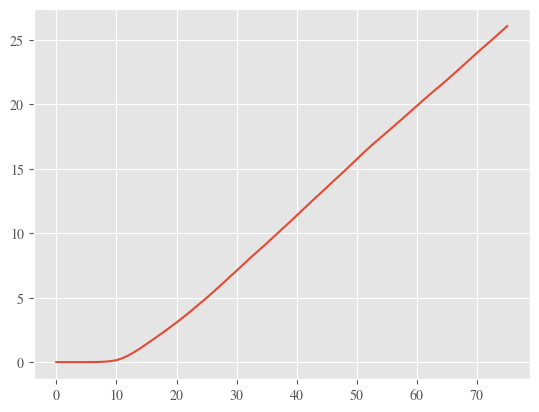

In [25]:
plt.plot(outfall_vols)

In [26]:
print(f'cw,co: {cw}, {co}')
print(f'Do new coupling: {do_new_coupling}')
print(20*'#')
print(f'Rain on surface: {do_surf_rain}')
print(f'Expand polygon: {expand_polygon}')
print(f'Zero velocity: {zero_velocity}')
print(f'baseline flows: {baseline_flows}')


cw,co: 0.6, 0.6
Do new coupling: True
####################
Rain on surface: False
Expand polygon: False
Zero velocity: True
baseline flows: [0.5, 0.0, 0.0, 0.0]


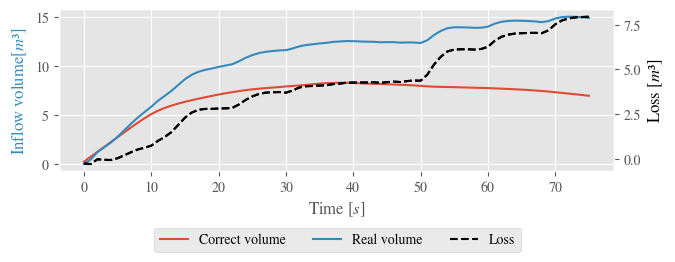

In [27]:
inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(times,correct_vols,label = 'Correct volume')
# ax.plot(times,np.array(correct_vols)-np.array(Q_in_cumsums),label = 'Coupled model')
ax.plot(times,real_vols,label = 'Real volume')

ax.set_ylabel('Inflow volume[$m³$]')
ax.set_xlabel('Time [$s$]')
ax.yaxis.label.set_color(ax.get_lines()[1].get_color())
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax.plot(times, numpy.array(applied_inflows)+np.array(boundary_fluxs)-np.array(outfall_vols)-np.sum(Q_ins,axis = 1),label = 'Applied - boundary')

diff_ax = ax.twinx()
diff_ax.plot(times,losses,label = 'Loss',color = 'k',linestyle = '--')
diff_ax.plot(times,np.array(real_vols)- np.array(correct_vols),label = 'Loss',color = 'k',linestyle = '--')

diff_ax.grid(False)
diff_ax.set_ylabel('Loss [$m³$]')
diff_ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# diff_ax.set_ylim([-0.5, 0.5])
# diff_ax.legend()

# ax.set_title(f'${baseline_flow}$m³/s on Inlet 1')
diff_ax.yaxis.label.set_color(diff_ax.get_lines()[0].get_color())
ax.plot([],[],color = 'k',linestyle = '--',label = 'Loss')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=2,ncol=4)
if False:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    # plt.savefig(plot_name + '.eps', bbox_inches='tight')
    # plt.savefig(plot_name + '.png', bbox_inches='tight')
    plt.savefig('plots/no_coupling_flooding_mass_conservation' + '.eps', bbox_inches='tight')
    plt.savefig('plots/no_coupling_flooding_mass_conservation' + '.png', bbox_inches='tight')

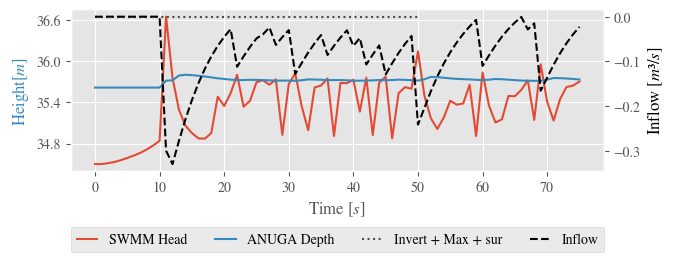

In [28]:
inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(times,np.array(node_heads)[:,2],label = 'SWMM Head')
# ax.plot(times,np.array(correct_vols)-np.array(Q_in_cumsums),label = 'Coupled model')
ax.plot(times,np.array(anuga_depths_out)[:,2] + inlet_elevation[2],label = 'ANUGA Depth')

ax.set_ylabel('Height[$m$]')
ax.set_xlabel('Time [$s$]')
ax.yaxis.label.set_color(ax.get_lines()[1].get_color())
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax.plot([0,50],[invert_elev[2] + inp.junctions.loc['Inlet_3'].Max_Depth,invert_elev[2] + inp.junctions.loc['Inlet_3'].Max_Depth],color = [0.4,0.4,0.4],linestyle = ':',label = 'Invert + Max')
ax.plot([0,50],[invert_elev[2] + inp.junctions.loc['Inlet_3'].Max_Depth + inp.junctions.loc['Inlet_3'].Surcharge_Depth,invert_elev[2] + inp.junctions.loc['Inlet_3'].Max_Depth + inp.junctions.loc['Inlet_3'].Surcharge_Depth],color = [0.3,0.3,0.3],linestyle = ':',label = 'Invert + Max + sur')

diff_ax = ax.twinx()
diff_ax.plot(times,np.array(Q_ins)[:,2],label = 'Loss',color = 'k',linestyle = '--')
diff_ax.grid(False)
diff_ax.set_ylabel('Inflow [$m³/s$]')
diff_ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# diff_ax.set_ylim([-0.5, 0.5])
# diff_ax.legend()

# ax.set_title(f'${baseline_flow}$m³/s on Inlet 3')
diff_ax.yaxis.label.set_color(diff_ax.get_lines()[0].get_color())
ax.plot([],[],color = 'k',linestyle = '--',label = 'Inflow')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)

plot_path + f'inflow_and_loss_inflow_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}'
if False:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(plot_path + f'depths_inflow_inlet_3_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}.eps', bbox_inches='tight')
    plt.savefig(plot_path + f'depths_inflow_inlet_3_{baseline_flow}_tavg_{time_average}_surd_{inp.junctions.loc["Inlet_3"].Surcharge_Depth}_maxd_{inp.junctions.loc["Inlet_3"].Max_Depth}.png', bbox_inches='tight')


In [29]:
if do_data_save and False:

    pick = outname + '.dat'

    data = {'times':times, 'conduit_depths':conduit_depths, 'node_heads':node_heads, 'Q_in':Q_in, 'inlet_vol_sum':sum(inlet_vol) }

    with open(pick, "wb") as f:
        pickle.dump(data, f)